In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist 

from lenskit.datasets import ML100K, MovieLens
from lenskit.algorithms import Recommender, als
from lenskit import batch

import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD, ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange, RecSimilarity, InteractionSimilarity, Measurement
from trecs.components import Users


In [2]:
GENERATOR = np.random.default_rng(1234)

In [3]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [4]:
class ShownMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="shown_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)
        predicted_shown_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                items_shown]

        shown_median=np.median(predicted_shown_vals)

        self.observe(shown_median)


In [5]:
class InteractedMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="interacted_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        interactions = kwargs.pop("interactions", None)
        
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractedMedianPrediction `measure` "
                "method as a keyword argument"
            )
        predicted_int_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                interactions]

        int_median=np.median(predicted_int_vals)

        self.observe(int_median)


In [6]:
model_params = {'iterations': 100}
# NUM_USERS = 500
# NUM_ITEMS= 1000
# N_FACTORS = 15

NUM_USERS = 100
NUM_ITEMS = 10000
N_FACTORS = 15
NUM_STARTUP = 20
NUM_STEPS = 105
js_pairs = [(u1_idx, u2_idx) for u1_idx in range(NUM_USERS) for u2_idx in range(NUM_USERS) if u1_idx != u2_idx] 

# user_rep = GENERATOR.normal(size=(NUM_USERS, N_FACTORS))
# #USERS = Users(size=(NUM_USERS, N_FACTORS), repeat_interactions=False)
# u = Users(actual_user_scores = user_rep, size=(NUM_USERS, N_FACTORS), num_users=NUM_USERS, repeat_interactions=False)



In [7]:
# user_representation = Generator().binomial(
#     n=1, p=.3, size=(NUM_USERS, N_FACTORS)
# )

# item_representation = Generator().binomial(
#     n=1, p=.3, size=(N_FACTORS, NUM_ITEMS)
# )
# # Initialize with custom representations
# filtering = ContentFiltering(user_representation=user_representation,
#                             item_representation=item_representation)

# filtering.add_metrics(AverageFeatureScoreRange())
# filtering.run(10)

# filtering.get_measurements()
#u = ChaneyUsers(np.copy(known_scores), size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_items=False)

In [8]:
#mf = ImplicitMF(num_users=NUM_USERS, num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
#                model_params=model_params)

mf = ImplicitMF(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)
#
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf.add_metrics(InteractionSimilarity(pairs=js_pairs))
mf.add_metrics(ShownMedianPrediction())
mf.add_metrics(InteractedMedianPrediction())
mf.add_state_variable(mf.predicted_scores)
mf.add_state_variable(mf.users.actual_user_scores)
mf.startup_and_train(NUM_STARTUP)
#mf.users.repeat_interactions=False
mf.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 17.02it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 105/105 [01:46<00:00,  1.01s/it]


In [9]:
mf.users.repeat_interactions

False

In [10]:
mflfd = ImplicitMFLFD(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), num_latent_factors=N_FACTORS, num_items_per_iter=10,
                     top_n_limit=50, model_params=model_params)
mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
#mflfd.add_metrics(RecSimilarity(pairs=js_pairs))
mflfd.add_metrics(InteractionSimilarity(pairs=js_pairs))
mflfd.add_metrics(ShownMedianPrediction())
mflfd.add_metrics(InteractedMedianPrediction())
mflfd.add_state_variable(mflfd.predicted_scores)
mflfd.add_state_variable(mflfd.users.actual_user_scores)
mflfd.startup_and_train(20)
mflfd.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mflfd.run(timesteps=NUM_STEPS)

100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


In [11]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mf_metrics = pd.DataFrame(mf.get_measurements())

In [24]:
def plot_metric(df1, df2, model1_lab, model2_lab, metric_var, ylab, title):
    #mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
    metric1= df1[metric_var].to_list()[1:]

    #mf_metrics = pd.DataFrame(mf.get_measurements())
    metric2= df2[metric_var].to_list()[1:]
    # style
    plt.style.use('seaborn-darkgrid')
    plt.rcParams.update({'font.size': 14})

    # create a color palette
    palette = plt.get_cmap('Set1')

    plt.plot(list(range(len(metric1))), metric1, marker='', color=palette(0), linewidth=1, alpha=0.9, label=model1_lab)
    plt.plot(list(range(len(metric2))), metric2, color=palette(1), linewidth=1, alpha=0.9, label=model2_lab)

    # Add legend
    #plt.legend(loc=2, ncol=2)
    plt.legend(loc=1, ncol=1)

    # Add titles
    plt.title(title, loc='center', fontsize=16, fontweight=2)
    plt.xlabel("Timestep")
    plt.ylabel(ylab)
    plt.show()


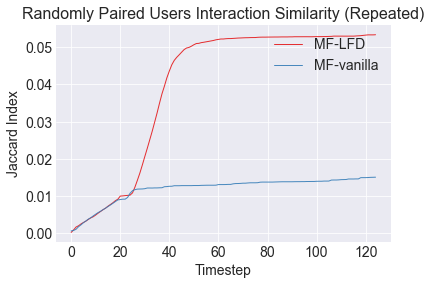

In [25]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='interaction_similarity', ylab="Jaccard Index", 
            title="Randomly Paired Users Interaction Similarity (Repeated)")

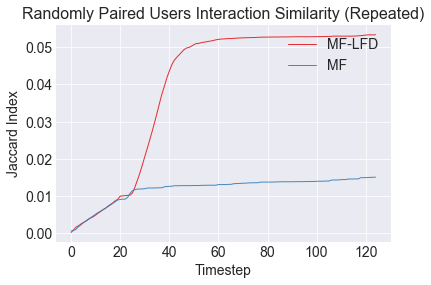

In [12]:
#mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mflfd_sim= mflfd_metrics['interaction_similarity'].to_list()[1:]

#mf_metrics = pd.DataFrame(mf.get_measurements())
mf_sim= mf_metrics['interaction_similarity'].to_list()[1:]
# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_sim))), mflfd_sim, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_sim))), mf_sim, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("Randomly Paired Users Interaction Similarity (Repeated)", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("Jaccard Index")
plt.show()


In [13]:
# mf_mean = np.mean(mf.predicted_scores.value, axis=0)
# plt.hist(mf_mean)
# plt.show()

# lfd_mean = np.mean(mflfd.predicted_scores.value, axis=0)
# plt.hist(lfd_mean)
# plt.show()

# plt.figure(figsize=(15, 15))
# plt.scatter(np.array(mf.predicted_scores.value).flatten(), mf.actual_user_item_scores.flatten())
# plt.xlabel("Predicted Scores")
# plt.ylabel("Actual Scores")

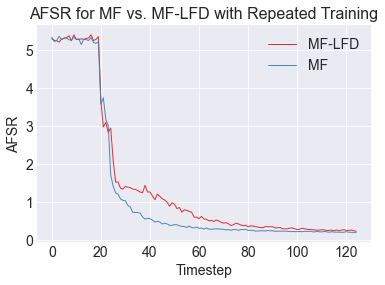

In [14]:
mf_afsr= mf_metrics['afsr'].to_list()[1:]
mflfd_afsr= mflfd_metrics['afsr'].to_list()[1:]

# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_afsr))), mflfd_afsr, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_afsr))), mf_afsr, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("AFSR for MF vs. MF-LFD with Repeated Training", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("AFSR")
plt.show()



In [15]:
mlsmall = MovieLens('../../MovieLens/data/ml-latest-small')
ratings=mlsmall.ratings

#make some fake interactions based on the ratings data
ratings["interaction"]=np.where(ratings["rating"]>=4, 1, 0)
ratings=ratings[ratings["interaction"]==1]
ratings = ratings[['user', 'item']]

algo_als = als.ImplicitMF(10, iterations=100)
algo_als.fit(ratings)
preds_als = batch.predict(algo_als, mlsmall.ratings)
#preds_als = pd.merge(preds_als, mlsmall.ratings, on=['user', 'item'])

preds_als.head(20)

,user,item,rating,timestamp,interaction,prediction
0,1,1,4.0,964982703,1,0.970280
1,1,3,4.0,964981247,1,0.767826
2,1,6,4.0,964982224,1,0.906331
3,1,47,5.0,964983815,1,0.901504
4,1,50,5.0,964982931,1,0.918515
5,1,70,3.0,964982400,0,0.734032
6,1,101,5.0,964980868,1,0.892564
7,1,110,4.0,964982176,1,0.985714
8,1,151,5.0,964984041,1,0.762035
9,1,157,5.0,964984100,1,0.513277


Text(0, 0.5, 'Actual Rating Scores')

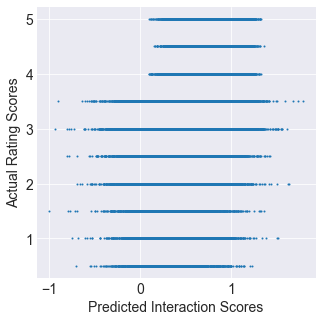

In [16]:
#preds_als.head(30)

plt.figure(figsize=(5, 5))
plt.scatter(preds_als["prediction"], preds_als["rating"], s=1)
plt.xlabel("Predicted Interaction Scores")
plt.ylabel("Actual Rating Scores")

In [17]:
als_item_features = pd.DataFrame(als.item_features_)
mflfd_item_features = pd.DataFrame(mflfd.items_hat.T)
#mflfd_item_features.head()

mf_item_features = pd.DataFrame(mf.items_hat.T)
#mf_item_features.head()

AttributeError: module 'lenskit.algorithms.als' has no attribute 'item_features_'

In [ ]:
def plot_hist_features(features_df, model_type, color='blue'):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Latent Factors for {}'.format(model_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        #hat = features_df[n_feature].tolist()
        features = features_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        #axs[r,c].plot(hat, actual, 'o', color=color);
        axs[r,c].hist(features, color=color)

    #for ax in axs.flat:
    #    ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

In [ ]:
plot_hist_features(als_item_features, 'MovieLens MF')

In [ ]:
plot_hist_features(mflfd_item_features, 'MF-LFD', 'red')

In [ ]:
plot_hist_features(mf_item_features, 'MF', 'green')

In [ ]:
mflfd_d = np.triu(pairwise_distances(mf.items_hat.value.T, metric="cosine"))

#mflfd_d[mflfd_d ==0] = np.nan
#arr[arr == 0] = 'nan' # or use np.nan
#mf_d = pairwise_distances(mflfd.items_hat, metric='correlation', force_all_finite="allow_nan")
#ml_d = pairwise_distances(als.item_features_.T, metric='correlation', force_all_finite="allow_nan")

print(mflfd_d.shape)
print(np.nanmean(mflfd_d))

In [ ]:


#Y = pdist(mflfd.items_hat, 'cosine')

In [ ]:
np.max(mflfd_d)

In [ ]:
mflfd

In [ ]:
upper = np.triu(mflfd_d)

In [ ]:
mflfd.predicted_scores.value.shape

In [ ]:
#https://stackoverflow.com/questions/9885529/indexing-numpy-2d-array-with-another-2d-array/45483577
predicted_rec_vals=mflfd.predicted_scores.value[np.expand_dims(np.arange(mflfd.predicted_scores.value.shape[0]), -1), 
                                                np.array(mflfd.rec)]

median_predicted_val = np.median(predicted_rec_vals)


In [ ]:
median_predicted_std = np.std(predicted_rec_vals)
median_predicted_std

In [ ]:
recommended_item_predictions = mflfd.predicted_scores.value[:, mflfd.rec]
recommended_item_predictions.shape

In [ ]:
mf.all_interactions.sort_values('user').head()

In [ ]:
mf_test = ImplicitMF(num_users=10, num_items=100, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)
#mf.add_metrics(MSEMeasurement())
#mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf_test.add_metrics(ShownMedianPrediction())
mf_test.add_metrics(InteractedMedianPrediction())
mf_test.add_state_variable(mf.predicted_scores)
#mf_test.add_state_variable(mf.users.actual_user_scores)
mf_test.startup_and_train(NUM_STARTUP)
mf_test.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

In [ ]:
mf_test_metrics = pd.DataFrame(mf_test.get_measurements())
mf_test_metrics.head(30)

In [ ]:
# mf_scores = pd.DataFrame(mf.predicted_scores.value)
# cols = [f"item_{c}" for c in mf_scores.columns]
# mf_scores.columns = cols
# #mf_scores.head()
# mf_scores["user"] = list(range(mf_scores.shape[0]))


# # t=pd.wide_to_long(mf_scores, "item_", i="user", j="item").reset_index()
# # t.columns = ["user", "item", "predicted_score"]

In [ ]:
# final_step_len = len(str(NUM_STEPS + NUM_STARTUP))

# for t in range(NUM_STEPS + NUM_STARTUP):

#     X=mflfd.predicted_scores.state_history[t].flatten()
#     Y=mflfd.users.actual_user_scores.state_history[t].flatten()

#     # plt.scatter(X, Y)
#     # plt.figure(figsize=(15, 15))

#     fig, ax = plt.subplots(figsize=(10,10))
#     fig.set_tight_layout(True)
#     ax.set(xlim=(-5, 5), ylim=(-5, 5))
#     ax.set_xlabel("Predicted Score")
#     ax.set_ylabel("Actual Score")
#     ax.scatter(X,Y, s=1, alpha=.7)
    
#     step_len=len(str(t))
    
#     num_leading_zeros = final_step_len-step_len
    
#     ext=str('0'*num_leading_zeros) + str(t)
    
    
    
    
    
#     # Save it & close the figure
#     filename='/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mflfd/scatter_step'+ext+'.png'
#     plt.savefig(fname=filename, dpi=96)
#     plt.gca()
#     plt.close(fig)

# import os
# os.chdir('/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mflfd')


In [ ]:
#!convert -delay 20 scatter*.png animated_scatter_mflfd.gif
